In [1]:
# Parameters
animal = "60-21"
col_names = ["time", "g1", "g2", "g3", "g4", "du1", "du2"]
chan_to_keep = ["time", "g1", "g2", "g3", "g4"]
new_sample_freq = 200
original_sample_freq = 2000
filter_type = "bandpass"
lo_cutoff = 0.05
hi_cutoff = 0.7
use_dropped_packet_removal = True
use_artifact_removal = True
pre_post_pts = 10
fill_frontend = True


# Load modules

In [2]:
# load modules
from rich import print
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# from directory_structure import Tree
import sys, os
import os.path as path
import glob
import re
import pickle

modules = path.abspath(path.join(os.getcwd(), "helpers"))
print(modules)
sys.path.insert(0, modules)

from import_files import *
from preprocessing import *
from plotting import *

%matplotlib inline

/home/github_repos/PITT_NN_paper/1_preprocessing/helpers

# Load data, rename columns, save/load to pickles to increase speed (and remove channels)

In [3]:
# get list of files and pickles
####################################

file_lst = glob.glob("Data/" + animal + "/*.txt")
print(file_lst)

pickle_lst = glob.glob("pickles/" + animal + "*.pckl")
print(pickle_lst)

# make df names
####################################

df_name_lst = []
for x in file_lst:
    if 'eed' in x:
        df_name_lst.append('df_feed')
    if 'ase' in x:
        df_name_lst.append('df_base')

# load pickles or make pickles
####################################

if len(file_lst) == len(pickle_lst):
    print("import pickles")
    for x, y in zip(pickle_lst, df_name_lst):
        print(y)
        df_x = Import.open_pickle(x)
        exec(y + " = df_x")
        print()
else:
    print("import CSVs and make pickles")
    for x, y in zip(file_lst, df_name_lst):
        print(y)
        df_x = Import.csv_import_to_pandas(file_path=x, df_name=y, print_df=False)
        df_x.columns = col_names
        # drop channel
        df_x = df_x[chan_to_keep]
        print(df_x)
        # store pickle
        # create directory if it does not exist
        file_path = 'pickles/'
        if not os.path.exists(file_path):
            os.mkdir(file_path)
        Import.store_pickle(obj=df_x, file_path='pickles/' + animal + '_' + y +'.pckl')
        exec(y + " = df_x")
        print()

['Data/60-21/60-21_Baseline_6-21-21.txt', 'Data/60-21/60-21_Feeding_6-23-21.txt']

['pickles/60-21_df_base.pckl', 'pickles/60-21_df_feed.pckl']

import pickles

df_base

time            g1            g2            g3            g4
0           0.0000 -68430.226563 -15481.198242  45582.949219 -40046.304688
1           0.0005 -68430.726563 -15486.235352  45871.628906 -40044.281250
2           0.0010 -68429.859375 -15487.092773  46278.210938 -40043.433594
3           0.0015 -68429.914063 -15482.999023  46431.726563 -40046.000000
4           0.0020 -68430.179688 -15479.350586  46115.832031 -40050.726563
...            ...           ...           ...           ...           ...
7200027  3600.0135 -69226.164063   3702.650879  23096.054688 -44530.960938
7200028  3600.0140 -69231.148438   3702.461914  22923.769531 -44532.773438
7200029  3600.0145 -69240.867188   3704.140869  22608.267578 -44535.300781
7200030  3600.0150 -69251.195313   3704.386230  22309.625000 -44536.703125
7200031  3600.0155 -69256.812500   3702.191162  22140.443359 -44536.417969

[7200032 rows x 5 columns]

df_feed

time            g1            g2            g3            g4
0           0.0000 -38265.007813 -14028.613281  19565.724609 -56230.589844
1           0.0005 -38266.003906 -14031.391602  19540.921875 -56230.175781
2           0.0010 -38265.480469 -14034.245117  19506.273438 -56230.593750
3           0.0015 -38262.625000 -14035.713867  19458.597656 -56232.015625
4           0.0020 -38260.015625 -14036.434570  19393.470703 -56233.480469
...            ...           ...           ...           ...           ...
7234572  3617.2860 -82820.562500 -29619.027344  16471.740234 -72475.210938
7234573  3617.2865 -82822.312500 -29619.650391  16531.679688 -72474.750000
7234574  3617.2870 -82824.906250 -29619.966797  16572.888672 -72474.312500
7234575  3617.2875 -82826.250000 -29621.007813  16565.625000 -72474.773438
7234576  3617.2880 -82825.757813 -29621.425781  16528.003906 -72474.656250

[7234577 rows x 5 columns]

## Determine percentage missing values

In [4]:
for x in df_name_lst:
    print(x)
    df1 = locals()[x]
    nans_lst, zeros_lst = Preprocessing.percent_nans_zeros_tolist(df=df1)
    print('nans')
    print(nans_lst[1:])
    print('zeros')
    print(zeros_lst[1:])
    print('#####################')
    print()

df_base

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

df_feed

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[4.7549, 4.7549, 4.7549, 4.7549]

#####################

# Downsample after applying anti-aliasing filter

In [5]:
factor = int(original_sample_freq / new_sample_freq)
print(factor)

for x in df_name_lst:

    df1 = locals()[x]

    # get df with time values
    df_x = df1.iloc[::factor, :].time
    df_x.reset_index(drop=True, inplace=True)
    df_x = pd.DataFrame(df_x)

    for y in chan_to_keep[1:]:    
        arr = Preprocessing.downsample_with_anti_aliasing(arr=df1[y], factor=factor, ftype='iir')
        df_x[y] = arr.tolist()

    exec(x + " = df_x")
    print(df_x)

10

Original length = 7200032
New length = 720004
Original length = 7200032


New length = 720004
Original length = 7200032
New length = 720004
Original length = 7200032


New length = 720004


time            g1            g2            g3            g4
0          0.000 -67647.207993 -15304.363531  45079.370965 -39587.502987
1          0.005 -67639.153490 -15303.065500  43922.828885 -39595.199851
2          0.010 -67628.336259 -15306.442155  41445.481751 -39599.386907
3          0.015 -67619.949103 -15311.580572  40480.744041 -39602.430477
4          0.020 -67610.771102 -15313.385143  39457.748984 -39609.190415
...          ...           ...           ...           ...           ...
719999  3599.995 -68188.011940   3632.632301  21742.899747 -43969.207416
720000  3600.000 -68260.918232   3653.134943  26001.351484 -43979.658033
720001  3600.005 -68328.547807   3663.774995  27623.193588 -43993.474726
720002  3600.010 -68394.081696   3665.255780  24305.177289 -44012.204918
720003  3600.015 -68458.452777   3662.299239  21597.171222 -44026.890220

[720004 rows x 5 columns]

Original length = 7234577
New length = 723458
Original length = 7234577


New length = 723458
Original length = 7234577
New length = 723458
Original length = 7234577


New length = 723458


time            g1            g2            g3            g4
0          0.000 -37826.338288 -13868.404888  19332.804234 -55586.922646
1          0.005 -37843.388884 -13876.295354  18723.709206 -55593.265592
2          0.010 -37936.925020 -13865.781087  18745.176844 -55602.281786
3          0.015 -38011.448436 -13868.223028  19608.861882 -55606.348470
4          0.020 -38041.242905 -13849.167169  19241.049622 -55608.450157
...          ...           ...           ...           ...           ...
723453  3617.265 -81874.428819 -29286.432006  16333.479880 -71627.155867
723454  3617.270 -81876.911105 -29286.730914  16350.765927 -71630.202302
723455  3617.275 -81878.138106 -29287.286638  16339.797348 -71633.805095
723456  3617.280 -81874.893487 -29284.250590  16320.625127 -71638.371343
723457  3617.285 -81875.429837 -29282.151251  16332.580978 -71643.737454

[723458 rows x 5 columns]

## Determine percentage missing values

In [6]:
for x in df_name_lst:
    print(x)
    df1 = locals()[x]
    nans_lst, zeros_lst = Preprocessing.percent_nans_zeros_tolist(df=df1)
    print('nans')
    print(nans_lst[1:])
    print('zeros')
    print(zeros_lst[1:])
    print('#####################')
    print()

df_base

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

df_feed

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

# Remove dropped packets (errors in the hardware recording)

In [7]:
if use_dropped_packet_removal:
    
    df_packet_drop = pd.DataFrame()
    
    removed_pct_lst = []
    cond_lst = []
    chan_lst = []

    for x in df_name_lst:
 
        df_x = locals()[x]
        
        for y in chan_to_keep[1:]:

            df_x[y], removed_pct = Preprocessing.remove_dropped_packets_zerofill(arr=df_x[y], thres=100000)
            removed_pct_lst.append(removed_pct)
            cond_lst.append(x)
            chan_lst.append(y)
            
        exec(x + ' = df_x')
 
    df_packet_drop['cond'] = cond_lst
    df_packet_drop['chan'] = chan_lst
    df_packet_drop['removed_pct'] = removed_pct_lst
    
    print(df_packet_drop)

cond chan  removed_pct
0  df_base   g1         0.45
1  df_base   g2         0.45
2  df_base   g3         1.30
3  df_base   g4         0.45
4  df_feed   g1         4.38
5  df_feed   g2         0.89
6  df_feed   g3         1.59
7  df_feed   g4         0.90

## Determine percentage missing values

In [8]:
for x in df_name_lst:
    print(x)
    df1 = locals()[x]
    nans_lst, zeros_lst = Preprocessing.percent_nans_zeros_tolist(df=df1)
    print('nans')
    print(nans_lst[1:])
    print('zeros')
    print(zeros_lst[1:])
    print('#####################')
    print()

df_base

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.44791, 0.4468, 1.30416, 0.44625]

#####################

df_feed

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[4.38104, 0.8928, 1.59083, 0.89528]

#####################

# Plot raw signals

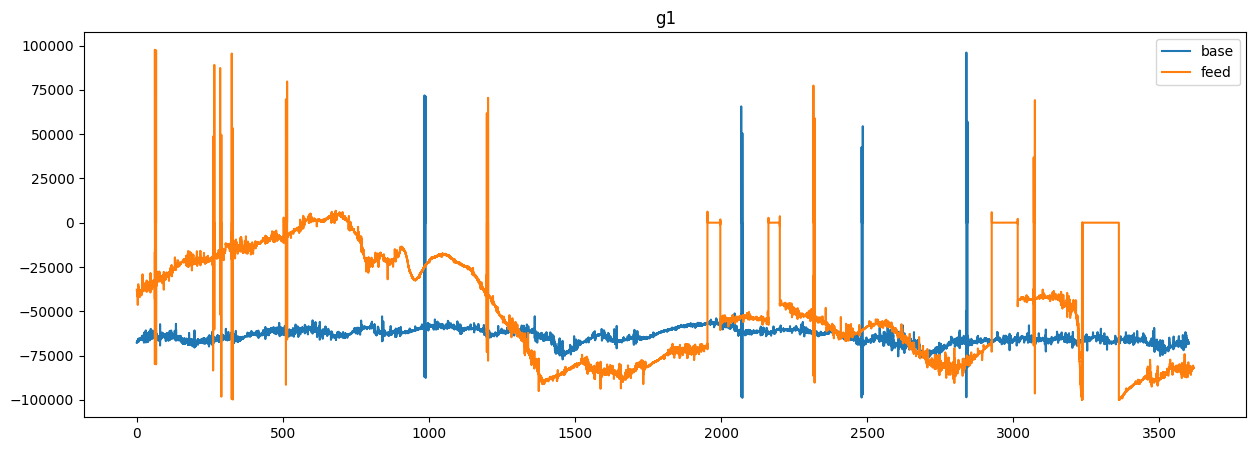

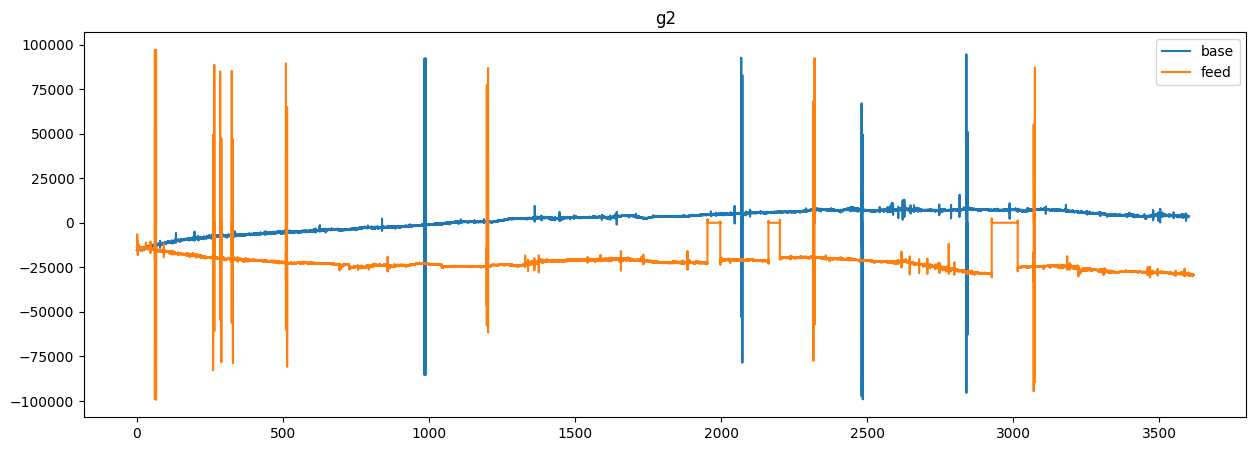

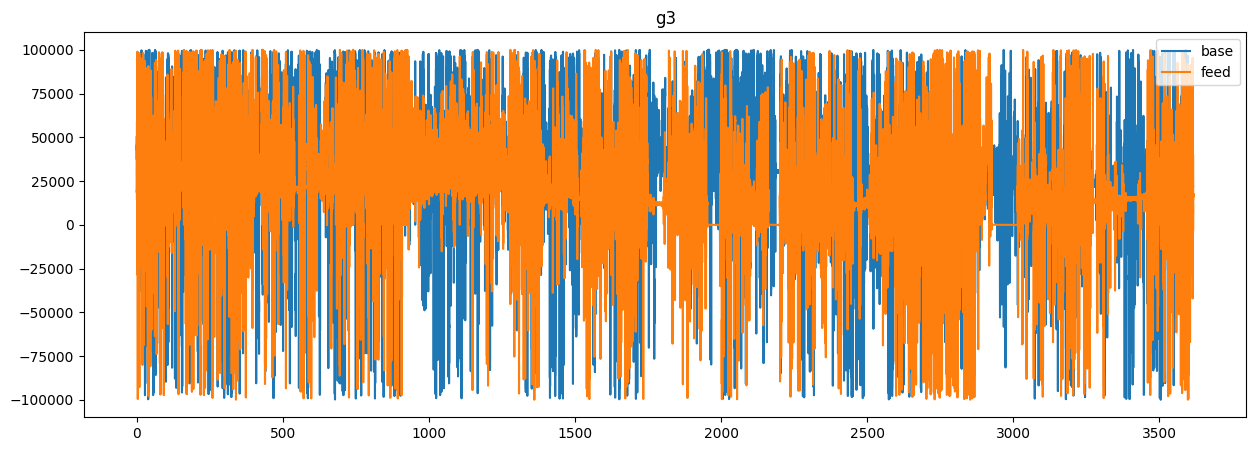

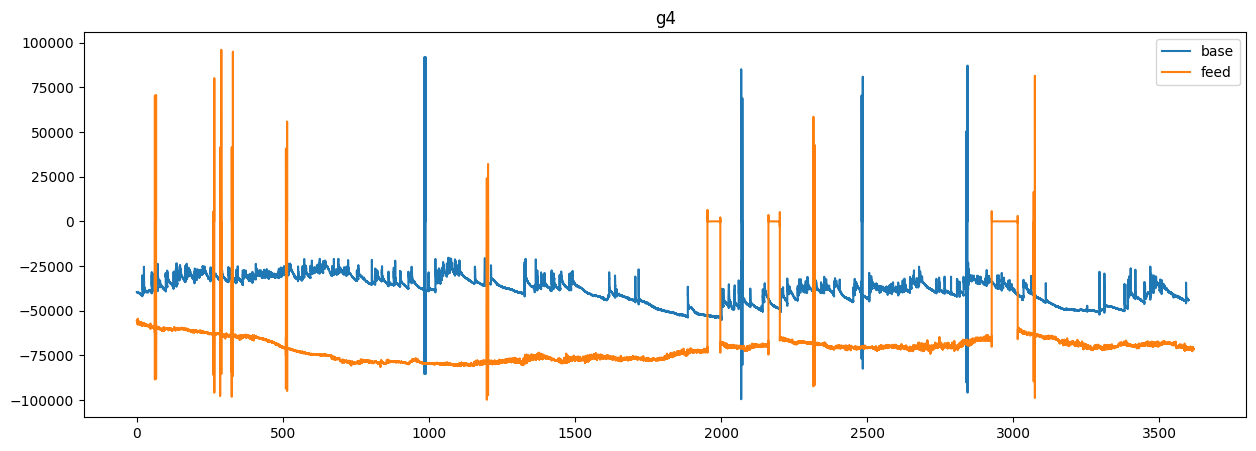

In [9]:
for x in chan_to_keep[1:]:
    plt.figure(figsize=(15,5))
    plt.title(x)
    plt.plot(df_base['time'], df_base[x], label='base')
    plt.plot(df_feed['time'], df_feed[x], label='feed')
    plt.legend(loc='upper right')

# Apply filters

## If band pass

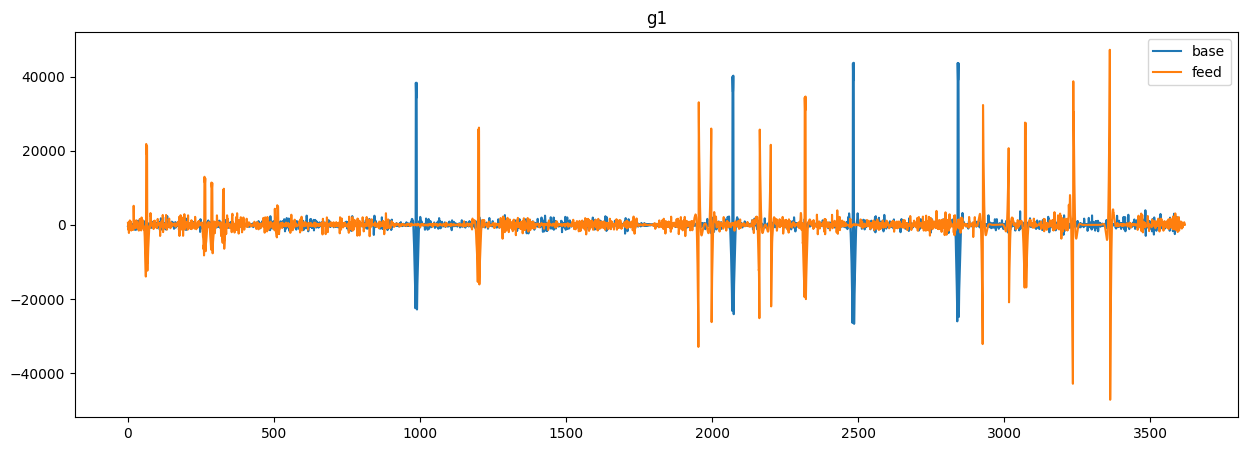

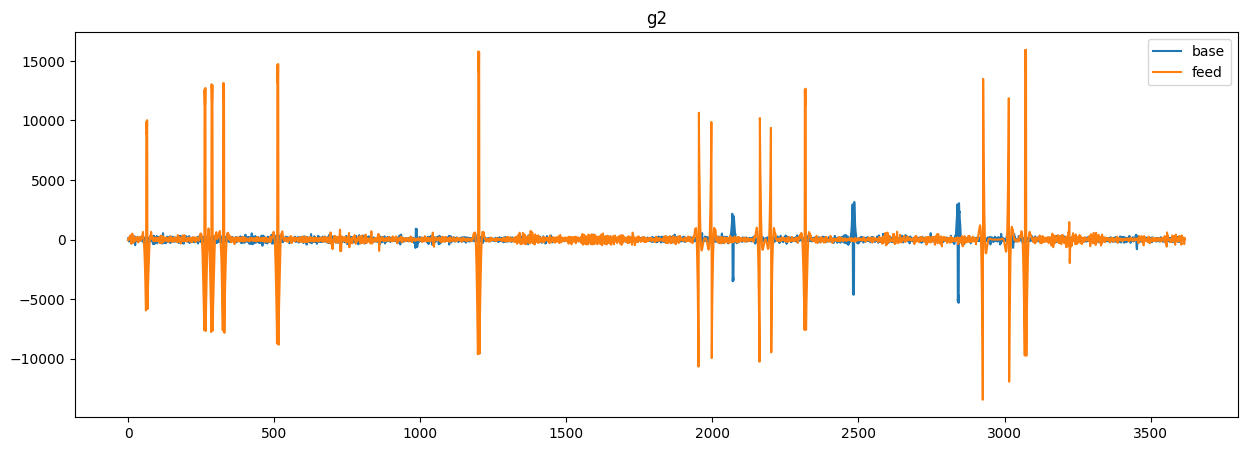

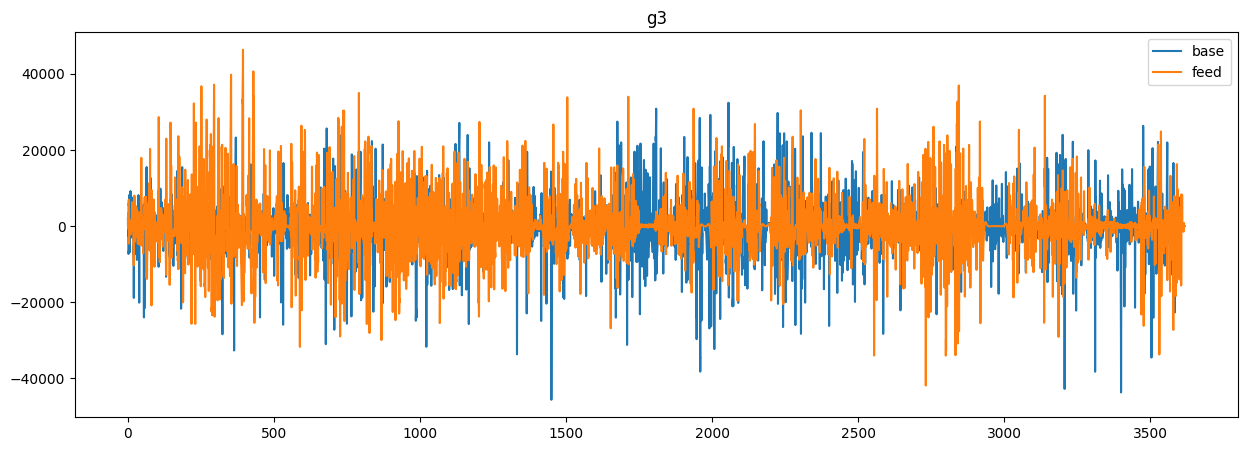

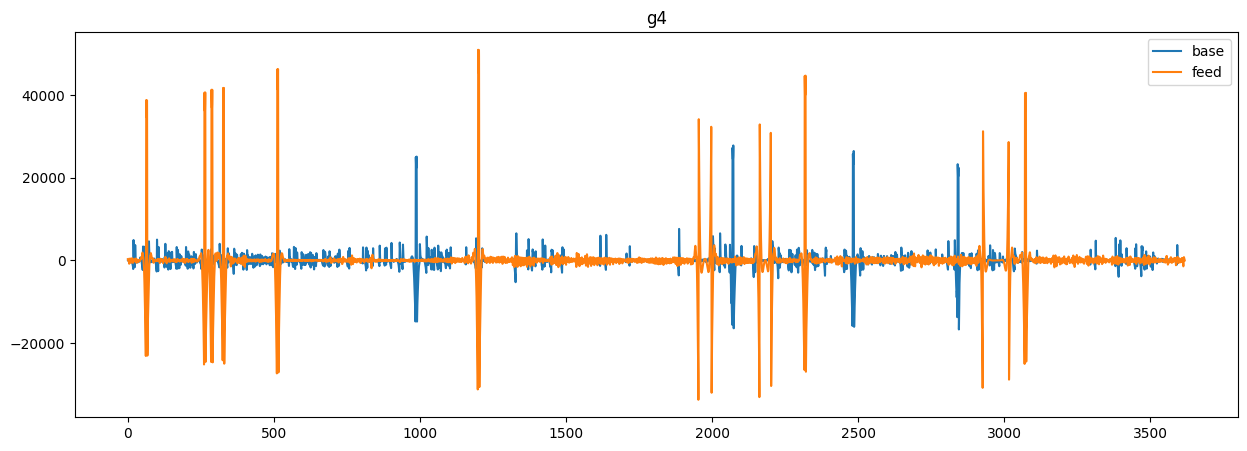

In [10]:
if filter_type == 'bandpass':
    
    for x in df_name_lst:
        df_x = locals()[x]
        for y in chan_to_keep[1:]:
            df_x[y] = Preprocessing.bandpass_butter_filter(arr=df_x[y], order=2, sample_freq=new_sample_freq, 
                                                           lowcut=lo_cutoff, highcut=hi_cutoff)
        exec(x + ' = df_x')

    for x in chan_to_keep[1:]:
        plt.figure(figsize=(15,5))
        plt.title(x)
        plt.plot(df_base['time'], df_base[x], label='base')
        plt.plot(df_feed['time'], df_feed[x], label='feed')
        plt.legend(loc='upper right')

## If high pass

In [11]:
if (filter_type == 'butter_high_low') or (filter_type == 'butter_high_savgol_low') or (filter_type == 'butter_high_only'):
    
    for x in df_name_lst:
        df_x = locals()[x]
        for y in chan_to_keep[1:]:
            df_x[y] = Preprocessing.highpass_butter_filter(arr=df_x[y], order=2, sample_freq=new_sample_freq, cutoff_freq=lo_cutoff)
        exec(x + ' = df_x')

    for x in chan_to_keep[1:]:
        plt.figure(figsize=(15,5))
        plt.title(x)
        plt.plot(df_base['time'], df_base[x], label='base')
        plt.plot(df_feed['time'], df_feed[x], label='feed')
        plt.legend(loc='upper right')

## If low pass

In [12]:
if filter_type == 'butter_high_low':
        
    for x in df_name_lst:
        df_x = locals()[x]
        for y in chan_to_keep[1:]:
            df_x[y] = Preprocessing.lowpass_butter_filter(arr=df_x[y], order=2, sample_freq=new_sample_freq, 
                                                           cutoff_freq=hi_cutoff)
        exec(x + ' = df_x')
        
    for x in chan_to_keep[1:]:
        plt.figure(figsize=(15,5))
        plt.title(x)
        plt.plot(df_base['time'], df_base[x], label='base')
        plt.plot(df_feed['time'], df_feed[x], label='feed')
        plt.legend(loc='upper right')

if filter_type == 'butter_high_savgol_low':
            
    for x in df_name_lst:
        df_x = locals()[x]
        for y in chan_to_keep[1:]:
            arr = Preprocessing.savitzky_golay_filter(arr=df_x[y].values, win_len=sg_len, order=sg_order)
            df_x[y] = pd.Series(arr)
        exec(x + ' = df_x')

    for x in col_names[1:]:
        plt.figure(figsize=(15,5))
        plt.title(x)
        plt.plot(df_base['time'], df_base[x], label='base')
        plt.plot(df_feed['time'], df_feed[x], label='feed')
        plt.legend(loc='upper right')

## Determine percentage missing values

In [13]:
for x in df_name_lst:
    print(x)
    df1 = locals()[x]
    nans_lst, zeros_lst = Preprocessing.percent_nans_zeros_tolist(df=df1)
    print('nans')
    print(nans_lst[1:])
    print('zeros')
    print(zeros_lst[1:])
    print('#####################')
    print()

df_base

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

df_feed

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

# Artifact removal > 2 mV

w/ Linear interpolation
w/ backfill on front end
Percentage removed: 3.04 %
w/ Linear interpolation
w/ backfill on front end
Percentage removed: 0.57 %
w/ Linear interpolation
w/ backfill on front end
Percentage removed: 51.15 %


w/ Linear interpolation
w/ backfill on front end
Percentage removed: 7.88 %


time          g1         g2           g3         g4
0          0.000 -297.330967 -40.565279  1980.602109  47.609148
1          0.005 -296.430225 -40.411218  1930.396825  47.279761
2          0.010 -295.526291 -40.241738  1880.040911  46.946505
3          0.015 -294.619582 -40.056582  1829.555445  46.609461
4          0.020 -293.710509 -39.855501  1778.960953  46.268711
...          ...         ...        ...          ...        ...
719999  3599.995    1.963943   0.144902    20.978200  -0.647881
720000  3600.000    1.709771   0.119910    17.770972  -0.550407
720001  3600.005    1.474310   0.098083    14.896098  -0.463223
720002  3600.010    1.257720   0.079193    12.339394  -0.385780
720003  3600.015    1.060068   0.063011    10.086382  -0.317517

[720004 rows x 5 columns]

w/ Linear interpolation
w/ backfill on front end
Percentage removed: 9.57 %


w/ Linear interpolation
w/ backfill on front end
Percentage removed: 4.8 %


w/ Linear interpolation
w/ backfill on front end
Percentage removed: 57.24 %


w/ Linear interpolation
w/ backfill on front end
Percentage removed: 7.59 %


time          g1         g2          g3          g4
0          0.000  553.088548 -53.018702  618.676873  340.661836
1          0.005  545.901601 -51.456451  657.625037  340.018777
2          0.010  538.674121 -49.895950  696.787130  339.364906
3          0.015  531.407996 -48.337916  736.150444  338.700383
4          0.020  524.105106 -46.783067  775.701713  338.025366
...          ...         ...        ...         ...         ...
723453  3617.265   -0.222734  -0.207456    1.357317    1.452864
723454  3617.270   -0.190853  -0.177458    1.162564    1.246374
723455  3617.275   -0.162020  -0.150392    0.986505    1.059337
723456  3617.280   -0.136118  -0.126132    0.828404    0.891039
723457  3617.285   -0.113022  -0.104546    0.687489    0.740724

[723458 rows x 5 columns]

cond chan  removed_pct
0  df_base   g1         3.04
1  df_base   g2         0.57
2  df_base   g3        51.15
3  df_base   g4         7.88
4  df_feed   g1         9.57
5  df_feed   g2         4.80
6  df_feed   g3        57.24
7  df_feed   g4         7.59

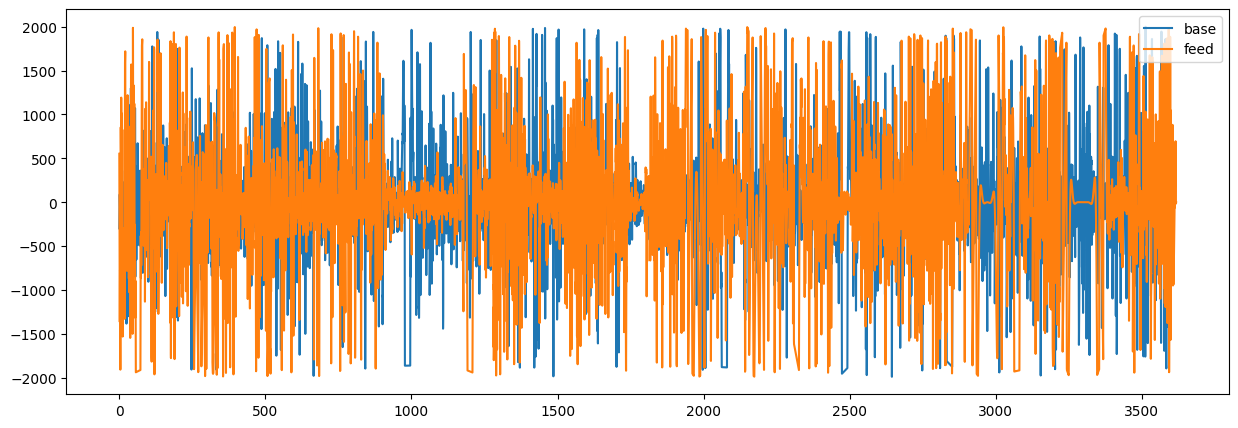

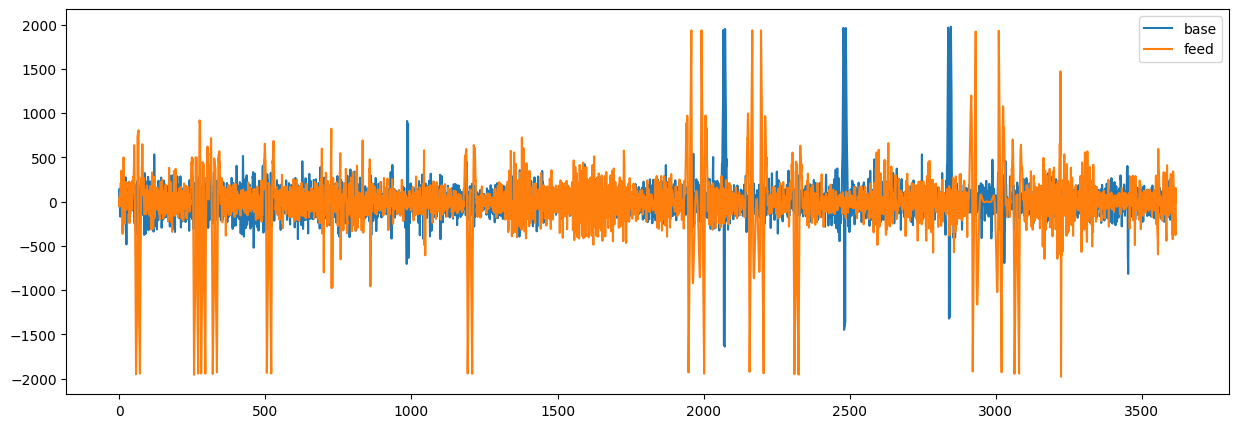

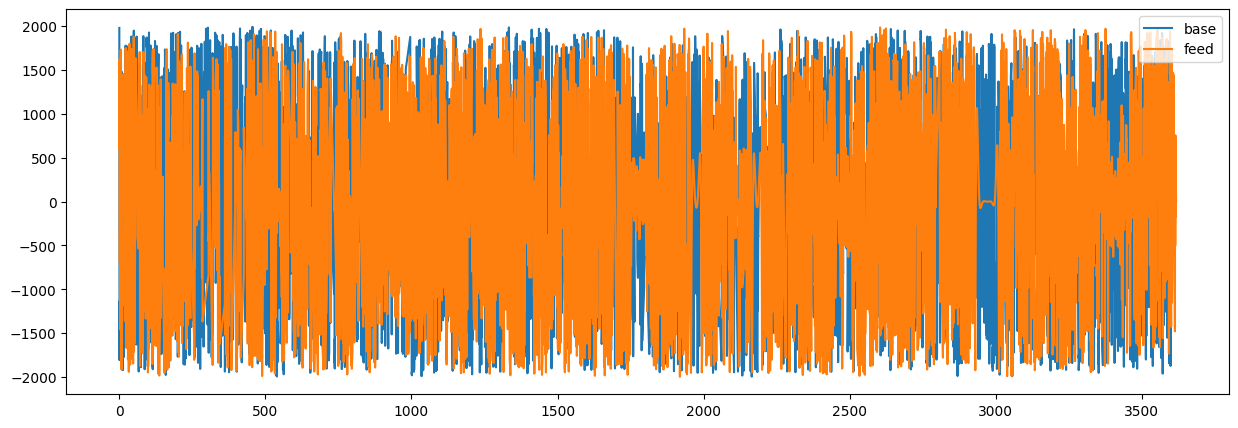

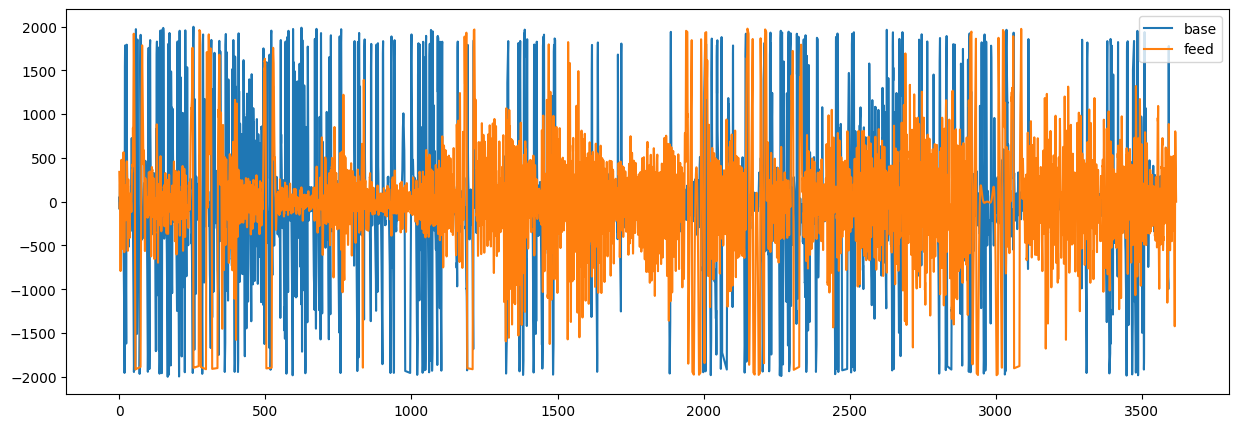

In [14]:
if use_artifact_removal:
    
    df_artifact_remove = pd.DataFrame()
    
    removed_pct_lst = []
    cond_lst = []
    chan_lst = []

    for x in df_name_lst:
 
        df_x = locals()[x]
        
        for y in chan_to_keep[1:]:
            
            # apply filter
            df_x[y], removed_pct = Preprocessing.artifacts_removal(arr=df_x[y], thres=2000, 
                                                                   pts_pre=pre_post_pts, 
                                                                   pts_post=pre_post_pts, 
                                                                   interpolate=True,
                                                                   fill_frontend=fill_frontend)
            removed_pct_lst.append(removed_pct)
            cond_lst.append(x)
            chan_lst.append(y)
        print(df_x)   
        exec(x + ' = df_x')
 
    df_artifact_remove['cond'] = cond_lst
    df_artifact_remove['chan'] = chan_lst
    df_artifact_remove['removed_pct'] = removed_pct_lst
    
    print(df_artifact_remove)

    for x in chan_to_keep[1:]:
        plt.figure(figsize=(15,5))
        plt.plot(df_base['time'], df_base[x], label='base')
        plt.plot(df_feed['time'], df_feed[x], label='feed')
        plt.legend(loc='upper right')

## Determine percentage missing values

In [15]:
for x in df_name_lst:
    print(x)
    df1 = locals()[x]
    nans_lst, zeros_lst = Preprocessing.percent_nans_zeros_tolist(df=df1)
    print('nans')
    print(nans_lst[1:])
    print('zeros')
    print(zeros_lst[1:])
    print('#####################')
    print()

df_base

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

df_feed

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

# Plots: power spectral density (from 3 to 15 cpm)

df_base

Total power = 295096753.44448864 Dom freq = 0.07777734568141288

Bradygastric power = 148000954.49371856 Dom freq = 0.07777734568141288

normygastric power = 85717957.52589794 Dom freq = 0.18166565741301438

tachygastric power = 61377841.42487211 Dom freq = 0.20388775617913235

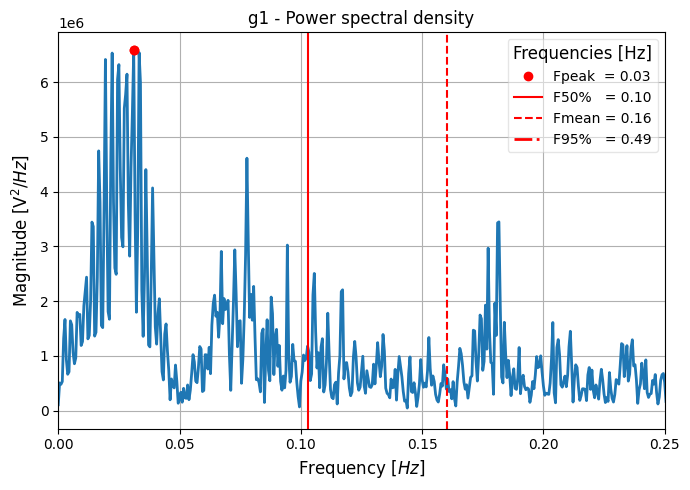

Total power = 72263069.13306981 Dom freq = 0.17555458025233195

Bradygastric power = 44820699.20408566 Dom freq = 0.0699996111132716

normygastric power = 24766015.484607466 Dom freq = 0.17555458025233195

tachygastric power = 2676354.4443766903 Dom freq = 0.19111004938861453

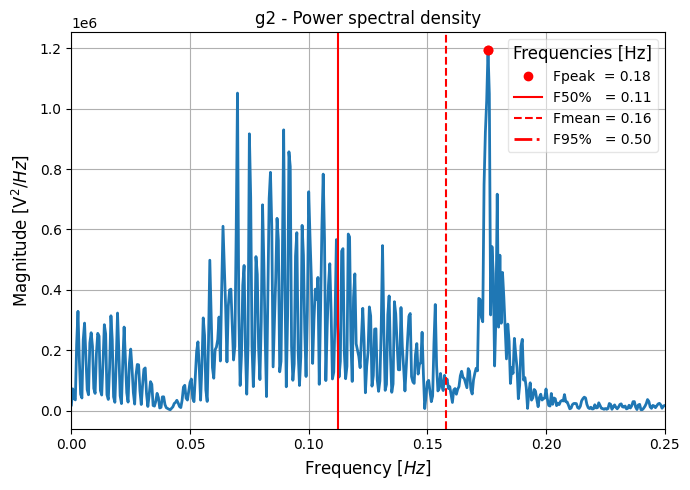

Total power = 867500182.0448079 Dom freq = 0.07388847839734224

Bradygastric power = 419897567.48326504 Dom freq = 0.07388847839734224

normygastric power = 259686623.11955363 Dom freq = 0.16499908333842592

tachygastric power = 187915991.44198915 Dom freq = 0.22166543519202672

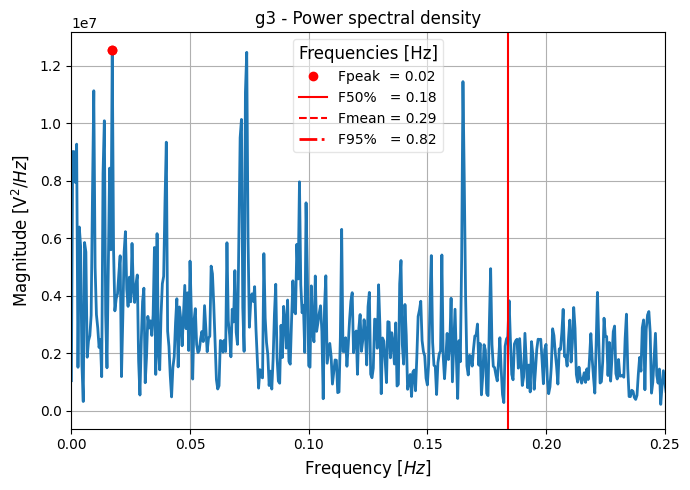

Total power = 670944015.2427888 Dom freq = 0.1761101327214849

Bradygastric power = 279951425.91346914 Dom freq = 0.08777729012616597

normygastric power = 297906163.2214318 Dom freq = 0.1761101327214849

tachygastric power = 93086426.1078879 Dom freq = 0.2011099938333676

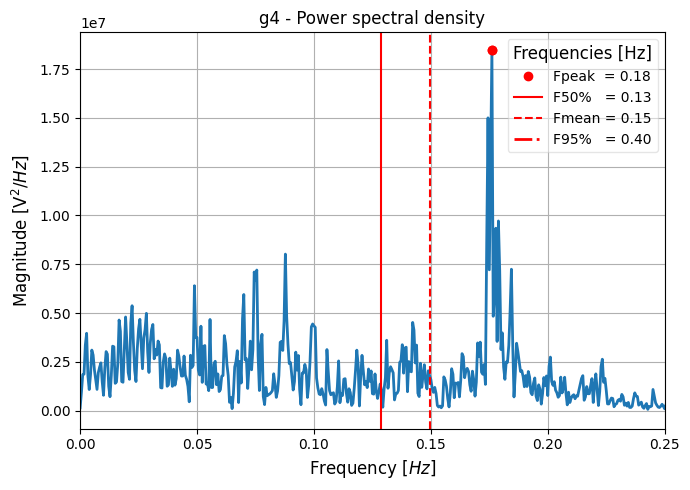

df_feed

Total power = 463979336.6903785 Dom freq = 0.058054510420784626

Bradygastric power = 307321622.0937581 Dom freq = 0.058054510420784626

normygastric power = 94355150.37320106 Dom freq = 0.1376721247121464

tachygastric power = 62302564.223419294 Dom freq = 0.19849113562915888

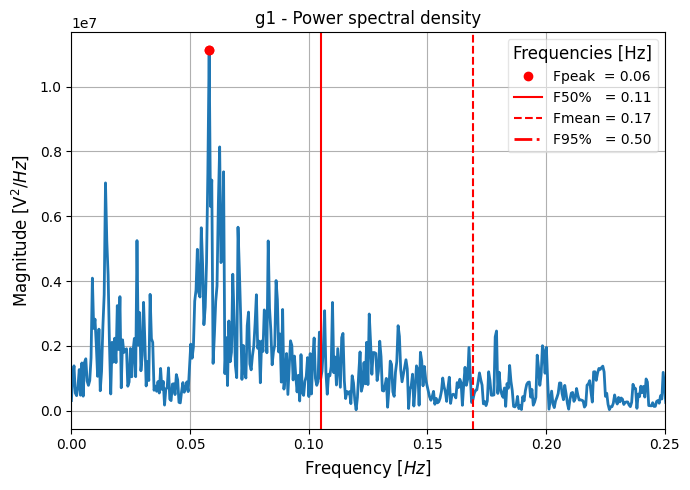

Total power = 138556327.83475533 Dom freq = 0.058054510420784626

Bradygastric power = 113527503.50211444 Dom freq = 0.058054510420784626

normygastric power = 17007217.47560779 Dom freq = 0.18632733344575636

tachygastric power = 8021606.857033092 Dom freq = 0.1979382355299133

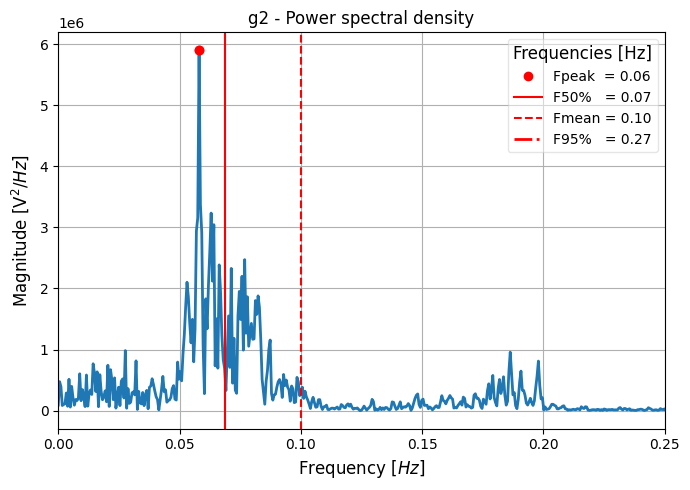

Total power = 874677847.4001448 Dom freq = 0.07685311379513393

Bradygastric power = 481184650.8692348 Dom freq = 0.07685311379513393

normygastric power = 229093056.49623454 Dom freq = 0.13214312371969072

tachygastric power = 164400140.03467542 Dom freq = 0.19240923453745762

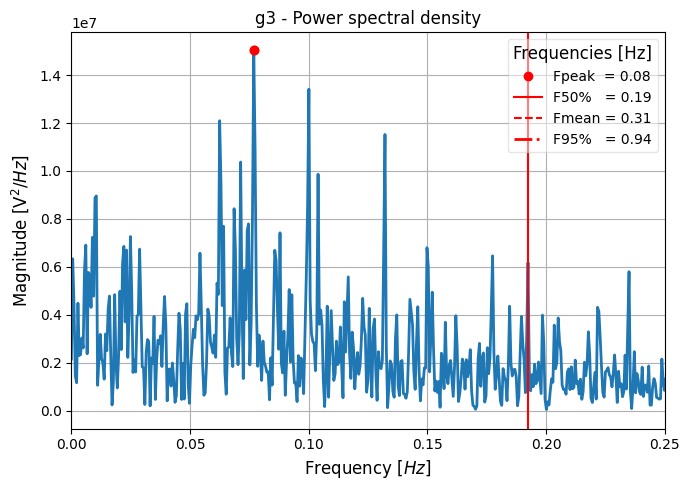

Total power = 414925194.2191708 Dom freq = 0.17858673205631842

Bradygastric power = 198583678.51306984 Dom freq = 0.058054510420784626

normygastric power = 186937914.1206942 Dom freq = 0.17858673205631842

tachygastric power = 29403601.5854068 Dom freq = 0.19019763414047536

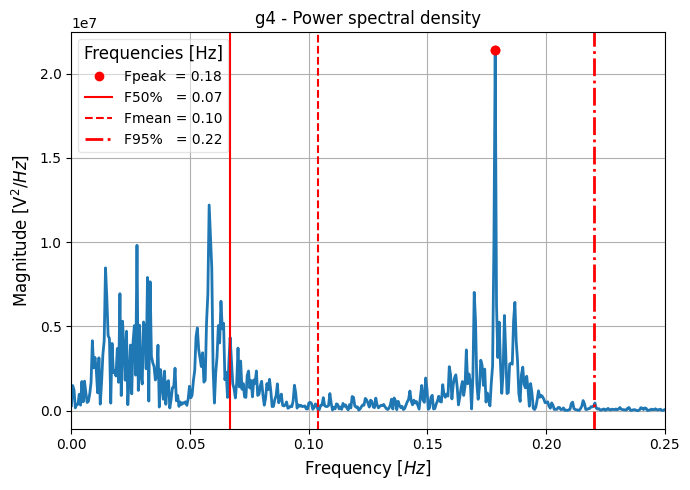

cond chan     tot_power    brad_power    norm_power    tach_power  \
0  df_base   g1  2.950968e+08  1.480010e+08  8.571796e+07  6.137784e+07   
0  df_base   g2  7.226307e+07  4.482070e+07  2.476602e+07  2.676354e+06   
0  df_base   g3  8.675002e+08  4.198976e+08  2.596866e+08  1.879160e+08   
0  df_base   g4  6.709440e+08  2.799514e+08  2.979062e+08  9.308643e+07   
0  df_feed   g1  4.639793e+08  3.073216e+08  9.435515e+07  6.230256e+07   
0  df_feed   g2  1.385563e+08  1.135275e+08  1.700722e+07  8.021607e+06   
0  df_feed   g3  8.746778e+08  4.811847e+08  2.290931e+08  1.644001e+08   
0  df_feed   g4  4.149252e+08  1.985837e+08  1.869379e+08  2.940360e+07   

   brad_domf  norm_domf  tach_domf  
0     0.0778     0.1817     0.2039  
0     0.0700     0.1756     0.1911  
0     0.0739     0.1650     0.2217  
0     0.0878     0.1761     0.2011  
0     0.0581     0.1377     0.1985  
0     0.0581     0.1863     0.1979  
0     0.0769     0.1321     0.1924  
0     0.0581     0.1786     0.1902

#########################################################

In [16]:
df_summary = pd.DataFrame()

for x in df_name_lst:
    
    print(x)

    df_x = locals()[x]
    
    for y in chan_to_keep[1:]:
        df_final = Plotting.psd(df_x[y], fs=new_sample_freq, xlim=[0,0.25], units='V', title=y, 
                                tot_pwr_lst=[0.05, 0.25], brad_pwr_lst=[0.05, 0.127], norm_pwr_lst=[0.127, 0.19], tach_pwr_lst=[0.19, 0.25])
        df_final['cond'] = x
        df_final['chan'] = y
        df_summary = pd.concat([df_summary, df_final])
    exec(x + '_summary = df_summary')

# change the order of columns and drop a column
df_summary = df_summary[['cond', 'chan', 'tot_power', 'brad_power', 'norm_power', 'tach_power', 'brad_domf', 'norm_domf', 'tach_domf']]
    
print(df_summary)

print('#########################################################')
print()

# Plot spectrograms

df_base

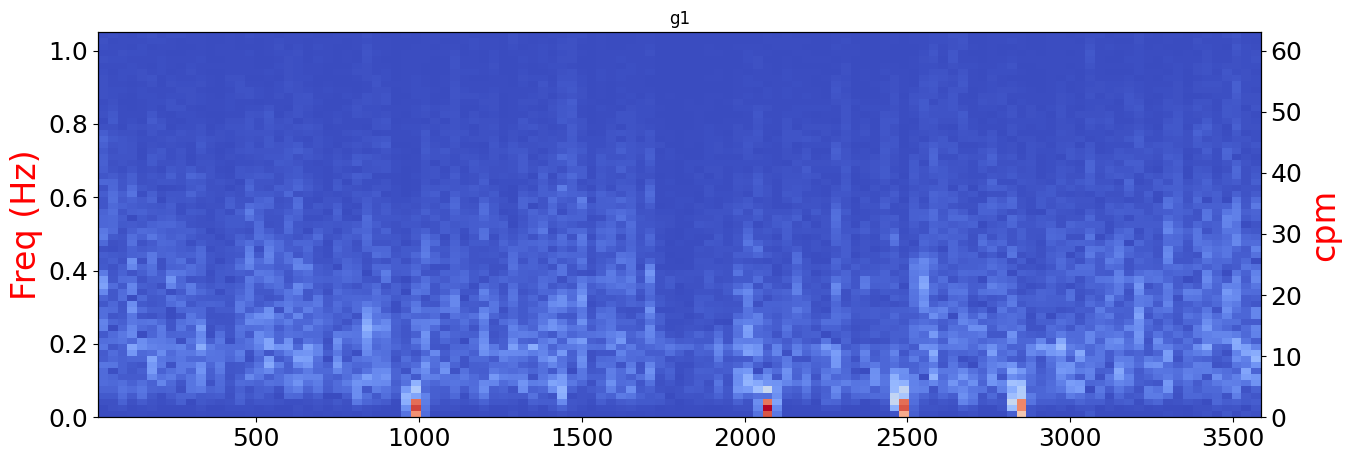

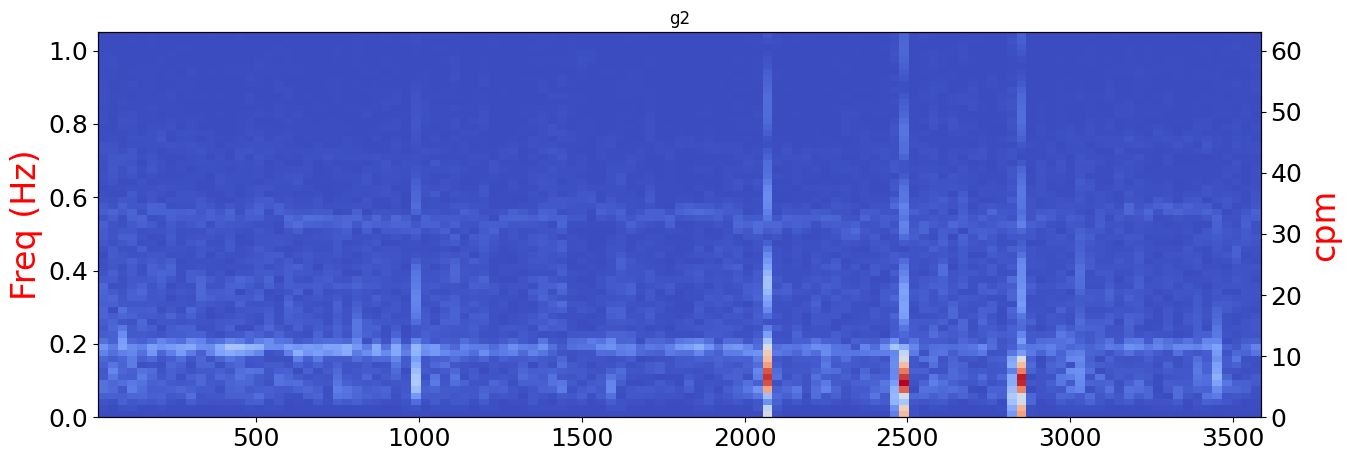

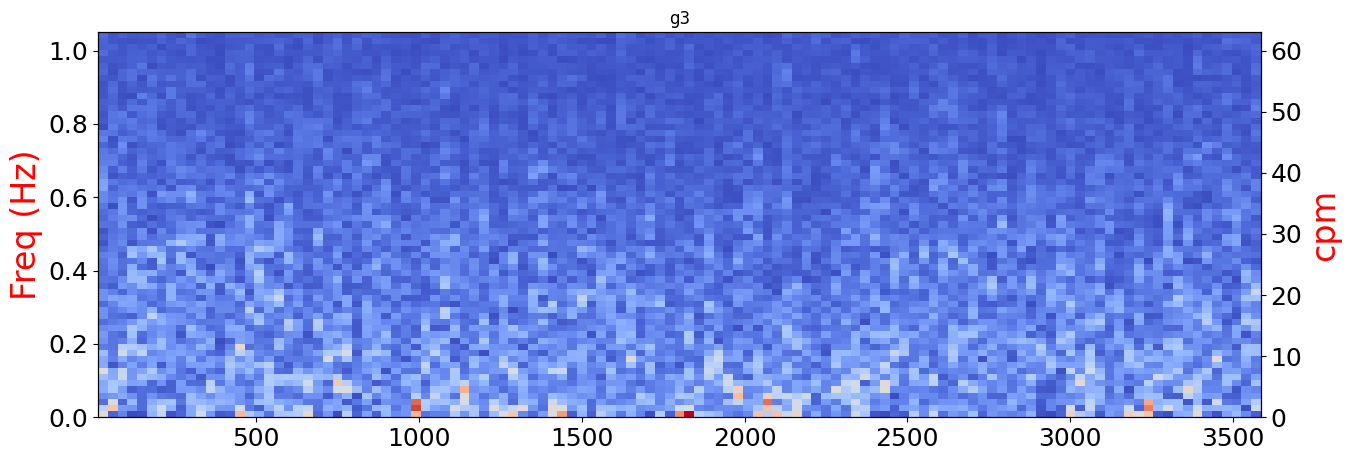

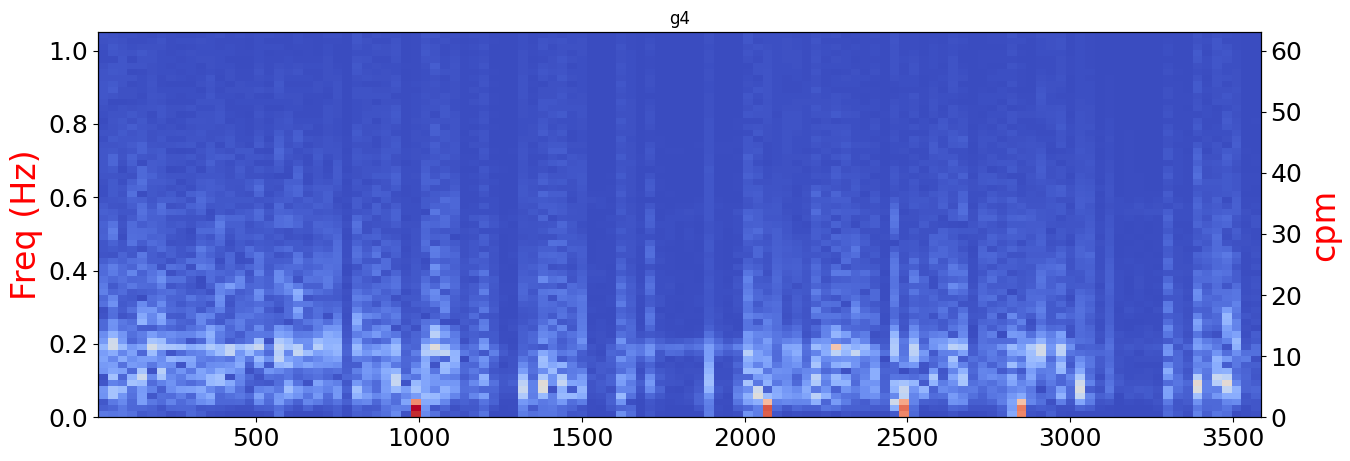

#########################################################

df_feed

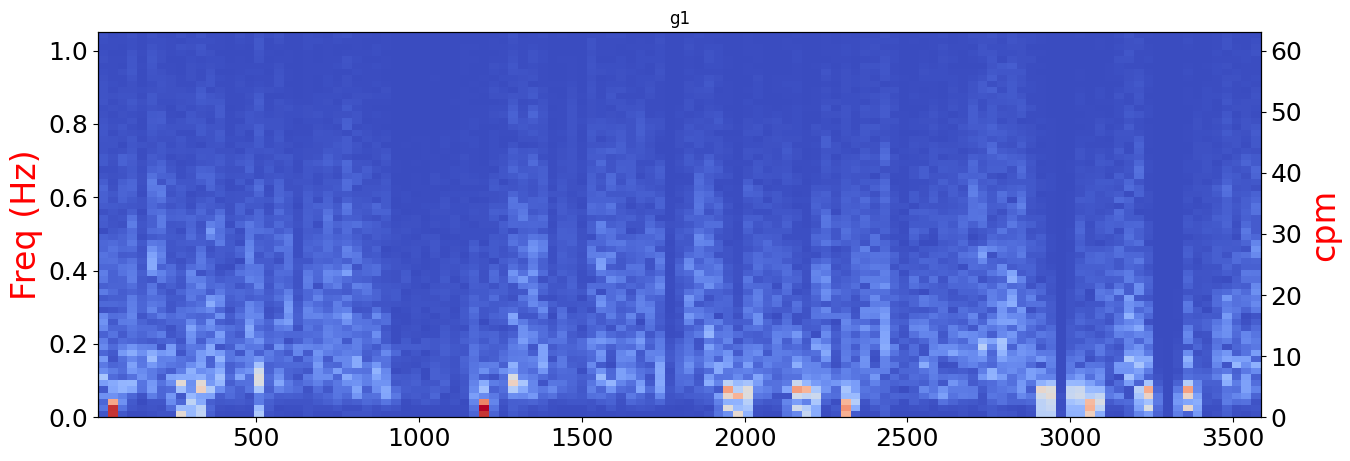

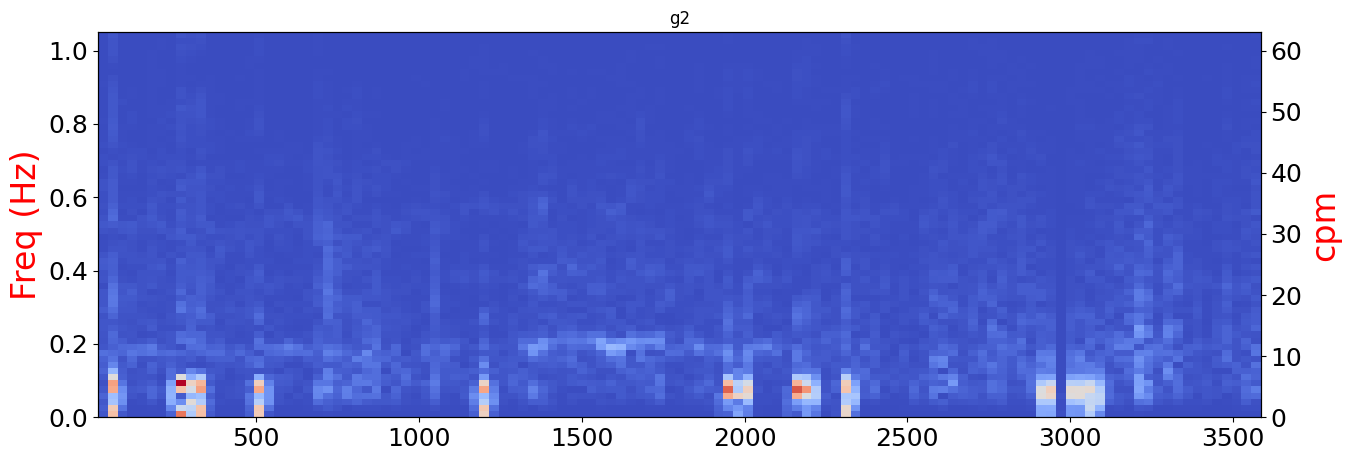

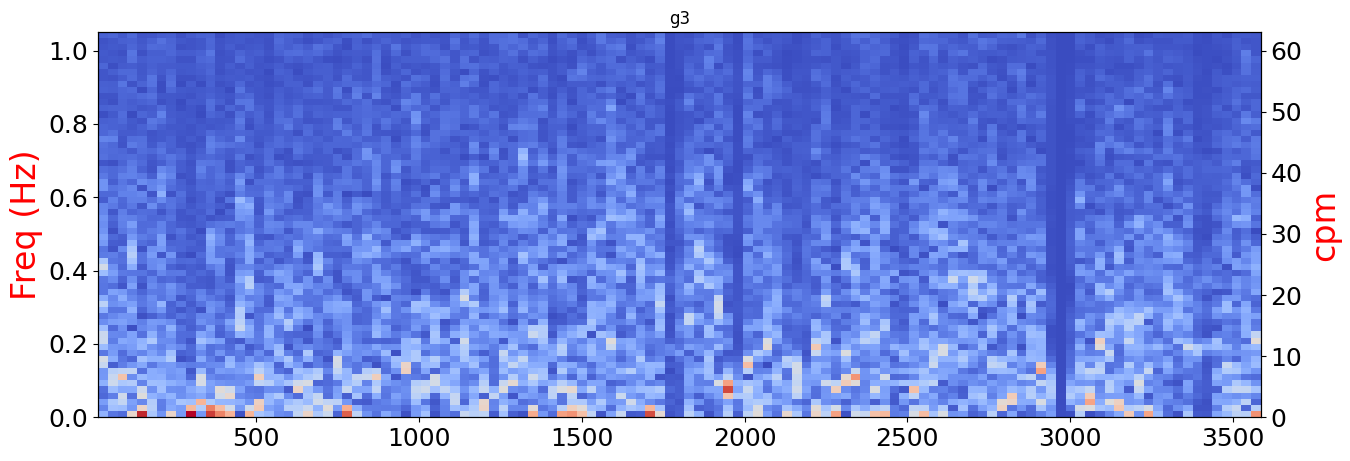

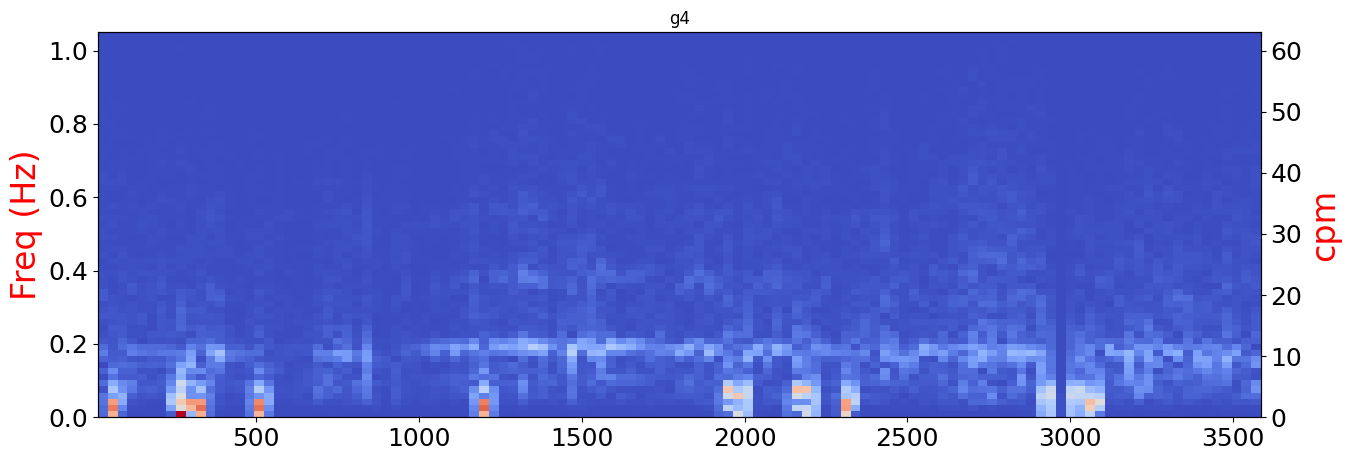

#########################################################

In [17]:
for x in df_name_lst:
    
    print(x)

    df_x = locals()[x]
    
    for y in chan_to_keep[1:]:
        Plotting.spect(arr=df_x[y], sample_freq=new_sample_freq, y_max_freq=1.5*hi_cutoff, plot_title=y)
        
    print('#########################################################')
    print()

# make summary table

In [18]:
# use deep = true to make sure that original will not be changed when modifying copy
df_copy = df_summary.copy(deep=True)

# add columns
df_copy['packet_remove_pct'] = df_packet_drop['removed_pct'].values
df_copy['art_remove_pct'] = df_artifact_remove['removed_pct'].values
df_copy['animal'] = pd.Series(animal, index=df_copy.index)
df_copy['new_sample_freq'] = pd.Series(new_sample_freq, index=df_copy.index)
df_copy['filter_type'] = pd.Series(filter_type, index=df_copy.index)
df_copy['lo_cutoff'] = pd.Series(lo_cutoff, index=df_copy.index)
df_copy['hi_cutoff'] = pd.Series(hi_cutoff, index=df_copy.index)
df_copy['remove_drop_packs'] = pd.Series(use_dropped_packet_removal, index=df_copy.index)
df_copy['remove_artifact'] = pd.Series(use_artifact_removal, index=df_copy.index)

# reorder columns
df_copy = df_copy[['animal', 'cond', 'chan', 'new_sample_freq', 'filter_type', 'lo_cutoff', 'hi_cutoff', 
                   'remove_drop_packs', 'remove_artifact', 'tot_power', 'brad_power', 
                   'norm_power', 'tach_power', 'brad_domf', 'norm_domf', 'tach_domf', 'packet_remove_pct', 'art_remove_pct']]

# replace characters
df_copy['cond'] = df_copy.cond.str.replace('df_', '')

print(df_copy)

# Write to file
results_file = 'summary.csv'

# make a results file
if not os.path.exists(results_file):
    os.mknod(results_file)
    df_copy.to_csv(results_file)  
elif os.path.exists(results_file):
    df_copy.to_csv(results_file, mode='a', header=False)

animal  cond chan  new_sample_freq filter_type  lo_cutoff  hi_cutoff  \
0  60-21  base   g1              200    bandpass       0.05        0.7   
0  60-21  base   g2              200    bandpass       0.05        0.7   
0  60-21  base   g3              200    bandpass       0.05        0.7   
0  60-21  base   g4              200    bandpass       0.05        0.7   
0  60-21  feed   g1              200    bandpass       0.05        0.7   
0  60-21  feed   g2              200    bandpass       0.05        0.7   
0  60-21  feed   g3              200    bandpass       0.05        0.7   
0  60-21  feed   g4              200    bandpass       0.05        0.7   

   remove_drop_packs  remove_artifact     tot_power    brad_power  \
0               True             True  2.950968e+08  1.480010e+08   
0               True             True  7.226307e+07  4.482070e+07   
0               True             True  8.675002e+08  4.198976e+08   
0               True             True  6.709440e+08  2.799514e+08   
0               True             True  4.639793e+08  3.073216e+08   
0               True             True  1.385563e+08  1.135275e+08   
0               True             True  8.746778e+08  4.811847e+08   
0               True             True  4.149252e+08  1.985837e+08   

     norm_power    tach_power  brad_domf  norm_domf  tach_domf  \
0  8.571796e+07  6.137784e+07     0.0778     0.1817     0.2039   
0  2.476602e+07  2.676354e+06     0.0700     0.1756     0.1911   
0  2.596866e+08  1.879160e+08     0.0739     0.1650     0.2217   
0  2.979062e+08  9.308643e+07     0.0878     0.1761     0.2011   
0  9.435515e+07  6.230256e+07     0.0581     0.1377     0.1985   
0  1.700722e+07  8.021607e+06     0.0581     0.1863     0.1979   
0  2.290931e+08  1.644001e+08     0.0769     0.1321     0.1924   
0  1.869379e+08  2.940360e+07     0.0581     0.1786     0.1902   

   packet_remove_pct  art_remove_pct  
0               0.45            3.04  
0               0.45            0.57  
0               1.30           51.15  
0               0.45            7.88  
0               4.38            9.57  
0               0.89            4.80  
0               1.59           57.24  
0               0.90            7.59

# make filtered files

In [19]:
if not os.path.exists('final_filt_data'):
    os.mkdir('final_filt_data')
    
for x in df_name_lst:

    df_x = locals()[x]    
    
    # make csv
    df_x.to_csv('final_filt_data/' + animal + '_' + x + '.csv', index=False)
    
    # make pickle
    f = open('final_filt_data/' + animal + '_' + x + '.pckl', 'wb')
    pickle.dump(df_x, f)
    f.close()